In [1]:
import random

from IPython.lib.deepreload import reload
from sklearn.model_selection import train_test_split

import utils.vis_utils as vis_util
import utils.dataset_processing_utils as dputil
from utils.models import *

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

random_forest_param_dict = {
    'bootstrap': [True],
    'max_features': range(1, 19), #range(1,len(d))
    'min_samples_leaf': [1, 2, 5, 8, 10, 15, 20, 25, 30], # expand options
    'n_estimators': [1000],
    'criterion': ['absolute_error']
}

#### Load the merged dataset that the pre-processing phase produced

In [2]:
processed_df = pd.read_csv("./data/final_dataframe.csv")

#### Apply normalization

In [3]:
per_capita_norm_df = dputil.normalize_by_column(processed_df,
                                         "population",
                                         {'seizure_volume': 'seizure_volume_per_capita',
                                          'total_crime_cases': 'crime_cases_per_capita', 
                                          'total_treatments': 'treatments_per_capita', 
                                          'gdp': 'gdp_per_capita', 
                                          'health_expenditure': 'health_exp_per_citizen',
                                          'border_length_km': 'border_len_per_capita',
                                          'coastline_length_km': 'coastline_len_per_capita'},
                                         ['offence_type']
                                         )
per_capita_norm_df = per_capita_norm_df.drop(columns='population')

per_capita_norm_df = dputil.fill_nans_by_map(per_capita_norm_df, {'health_exp_per_citizen': 0,
                                                                  'gdp_per_capita': 0,
                                                                  'crime_cases_per_capita': 0,
                                                                  'recreational_year': 2999,
                                                                  'medical_year': 2999,
                                                                  'decriminalized_max_possession': 0,
                                                                  'crime_count_gender_ratio': 0.5})

#### Merge drug groups
**“Ecstasy”-type substances** group is technically a part of the **Amphetamine-type stimulants (excluding “ecstasy”)** drug_group, since “Ecstasy” is also a type of Amphetamine.

It'll also help us increase the number of datapoints for this drug type

In [4]:
per_capita_norm_df['drug_group'].unique()

array(['Amphetamine-type stimulants (excluding “ecstasy”)',
       'Cannabis-type drugs (excluding synthetic cannabinoids)',
       'Cocaine-type', 'Opioids', 'Hallucinogens',
       'Sedatives and tranquillizers', '“Ecstasy”-type substances'],
      dtype=object)

In [5]:
per_capita_norm_df.loc[per_capita_norm_df["drug_group"]=='Amphetamine-type stimulants (excluding “ecstasy”)', 'drug_group'] = 'Amphetamine-type stimulants'
per_capita_norm_df.loc[per_capita_norm_df["drug_group"]=='“Ecstasy”-type substances', 'drug_group'] = 'Amphetamine-type stimulants'

# average on all years
per_capita_agg_years_df = per_capita_norm_df.groupby(['region', 'country', 'drug_group', 'drug_sub_group']).agg(seizure_volume_per_capita=('seizure_volume_per_capita', 'mean'),
                                                                                                                crime_cases_per_capita=('crime_cases_per_capita', 'mean'),
                                                                                                                treatments_per_capita=('treatments_per_capita', 'mean'),
                                                                                                                gdp_per_capita=('gdp_per_capita', 'mean'),
                                                                                                                health_exp_per_citizen=('health_exp_per_citizen', 'mean'),
                                                                                                                border_len_per_capita=('border_len_per_capita', 'mean'),
                                                                                                                coastline_len_per_capita=('coastline_len_per_capita', 'mean')
                                                                                                                )

#### Split dataset into sub-datasets by drug_group

We decided to focus on three drug_groups which represent hard drugs we'd like to predict the treatment cases per capita to, with the intent to see if policy has some sort of impact on its estimation.

The groups are as follows:
- Amphetamine type substances
- Cocaine type drugs
- Opioids 

In [6]:
amphetamines_norm_df = per_capita_norm_df[per_capita_norm_df["drug_group"]=='Amphetamine-type stimulants']
cocaine_norm_df = per_capita_norm_df[per_capita_norm_df["drug_group"]=='Cocaine-type']
opioids_norm_df = per_capita_norm_df[per_capita_norm_df["drug_group"]=='Opioids']

### Amphetamine type drugs modelling
#### train-test split

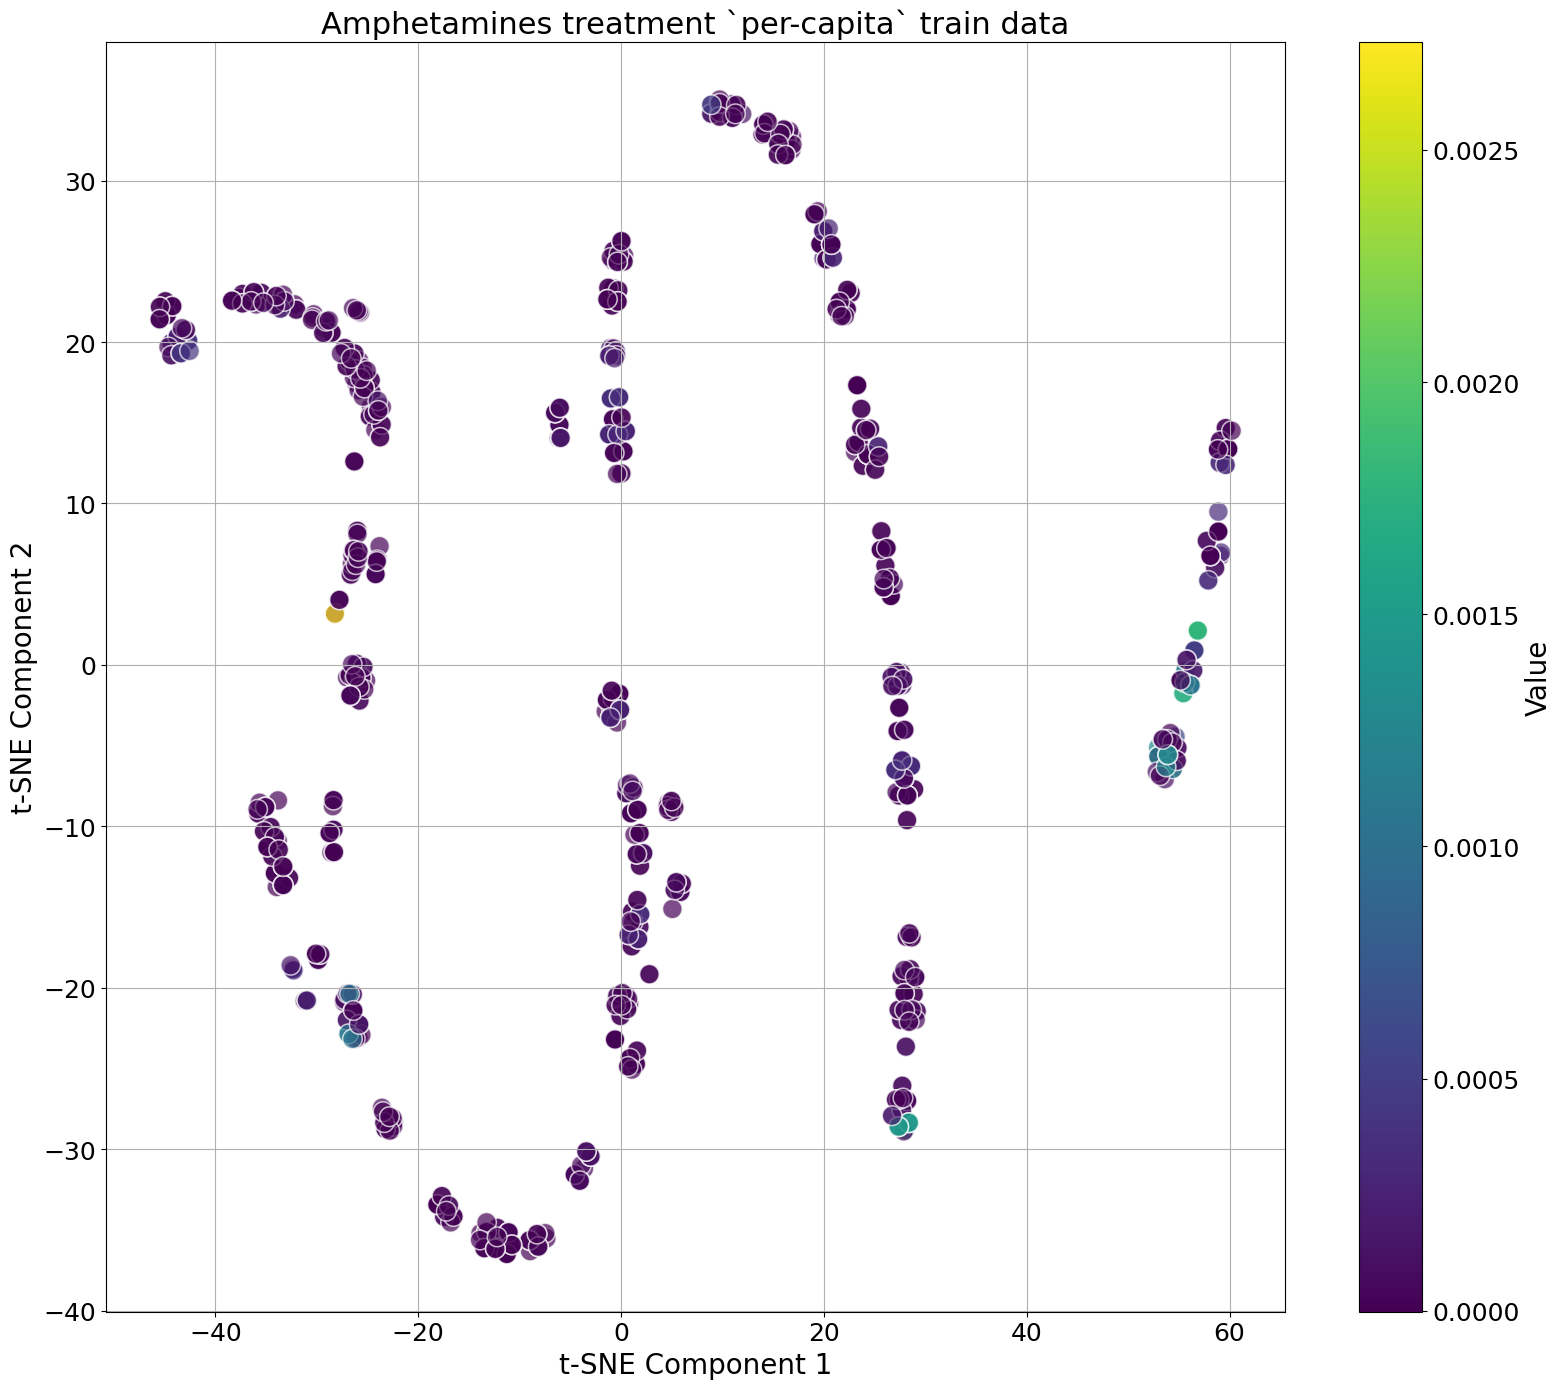

In [7]:
amphetamines_y = amphetamines_norm_df['treatments_per_capita'].values.reshape((-1, 1))
amphetamines_X = amphetamines_norm_df.copy().drop(columns=['treatments_per_capita']).select_dtypes(include='number')
amphetamines_X_train, amphetamines_X_test, amphetamines_y_train, amphetamines_y_test = train_test_split(amphetamines_X, amphetamines_y, test_size=0.15, shuffle=True, random_state=SEED)
vis_util.plot_tsne(amphetamines_X_train, amphetamines_y_train, 'Amphetamines treatment `per-capita` train data', colorbar=True)

The above t-SNE plot shows the Amphetamine-related data representation. The colouring indicates the treatment cases per capita. As you can see, most countries have a low value of treatments per capita. However, they're not linearly separable as you can see from the clusters with a mix for treatment values.

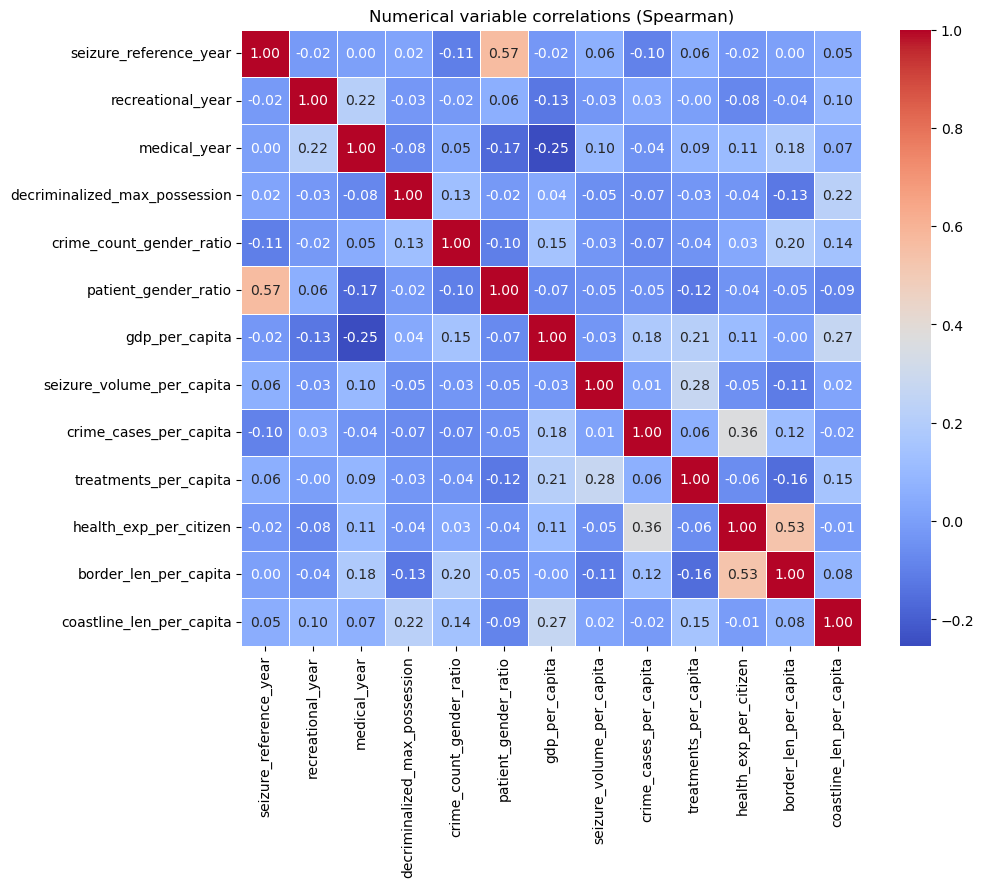

In [8]:
vis_util.plot_correlation_matrix(amphetamines_norm_df.select_dtypes(include='number'), title="Numerical variable correlations (Spearman)", colors="coolwarm", save_path="./images/amphetamines_correlation_matrix.png")

#### Linear models with regularization training
**L1 regularization - Lasso regression**

In [ ]:
print("Init lasso model")
amphetamines_lasso = LassoRegressionModel(SEED, n_iter=10000)
print("Done")
print("Training lasso model:")
amphetamines_lasso.fit(amphetamines_X_train, amphetamines_y_train)
print("Done")
print(f"Alpha of best lasso model: {amphetamines_lasso.best_alpha}")
amphetamines_lasso.get_train_score(amphetamines_X_train, amphetamines_y_train)
print("Test lasso model:")
amphetamines_lasso_y_pred = amphetamines_lasso.predict(amphetamines_X_test)
print("Amphetamine lasso estimator test score:")
get_mad_score(amphetamines_y_test, amphetamines_lasso_y_pred, print_version=True)
get_r_square_score(amphetamines_y_test, amphetamines_lasso_y_pred, print_version=True)

**L2 regularization - Ridge regression**

In [10]:
print("Init ridge model")
amphetamines_ridge = RidgeRegressionModel()
print("Done")
print("Training ridge model:")
amphetamines_ridge.fit(amphetamines_X_train, amphetamines_y_train)
print("Done")
print(f"Alpha of best ridge model: {amphetamines_ridge.alpha}")
print("Coefficients of model", amphetamines_ridge.coefficients)
amphetamines_ridge.get_train_score(amphetamines_X_train, amphetamines_y_train)
print("Test ridge model:")
amphetamines_ridge_y_pred = amphetamines_ridge.predict(amphetamines_X_test)
print("Amphetamine ridge estimator test score:")
get_mad_score(amphetamines_y_test, amphetamines_ridge_y_pred, print_version=True)
get_r_square_score(amphetamines_y_test, amphetamines_ridge_y_pred, print_version=True)

Init ridge model
Done
Training ridge model:
Done
Alpha of best ridge model: 10.0
Coefficients of model [ 3.15922925e-05  4.80877172e-08  5.61118792e-08 -9.91240995e-07
 -2.02678015e-05 -7.69779061e-05  2.91611713e-09  9.99174096e-07
  1.27997684e-06 -2.47278249e-08 -1.31175874e-06  1.65408534e-06]
Ridge regression R square score for train set: 8.457969e-02
Test ridge model:
Amphetamine ridge estimator test score:
MAD score for test set: 4.649268e-05
R-square score for test set: 1.473034e-01


**Random Forest regression model**

In [ ]:
print("Init RF model")
amphetamines_rf = RandomForestModel(random_forest_param_dict, SEED)
print("Done")
print("Training RF model:")
amphetamines_rf.fit(amphetamines_X_train, amphetamines_y_train)
print("Done")
amphetamines_rf.get_train_score()
print("Test RF model:")
amphetamines_rf_y_pred = amphetamines_rf.predict(amphetamines_X_test)
print("Amphetamine RF estimator test score:")
get_mad_score(amphetamines_y_test, amphetamines_rf_y_pred, print_version=True)
get_r_square_score(amphetamines_y_test, amphetamines_rf_y_pred, print_version=True)

Init RF model
Done
Training RF model:


#### Amphetamine model comparison

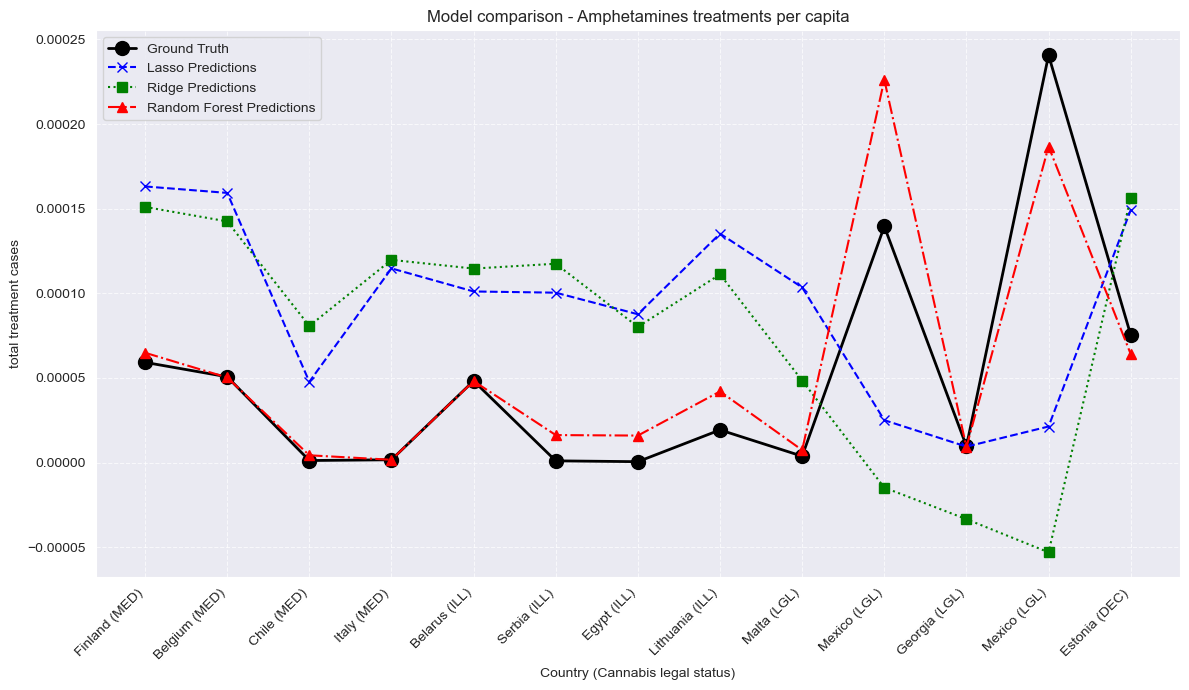

In [32]:
sample_df = dputil.create_subset_by_legal_category_for_plot(amphetamines_norm_df.loc[amphetamines_X_test.index, :],
                                                            {"lasso_preds": amphetamines_lasso_y_pred,"ridge_preds": amphetamines_ridge_y_pred,"rf_preds": amphetamines_rf_y_pred})
vis_util.plot_model_predictions(gt_values=sample_df["treatments_per_capita"],
                                lasso_predictions=sample_df['lasso_preds'],
                                ridge_predictions=sample_df['ridge_preds'],
                                rf_predictions=sample_df['rf_preds'],
                                x_tick_labels=[f"{r['country']} ({r['legal_category']})" for _, r in sample_df.iterrows()],
                                title="Model comparison - Amphetamines treatments per capita",
                                save_path="./images/amphetamines_model_comparison.png")

#### Amphetamine models feature importance
**Random Forest feature importance - using MDI**

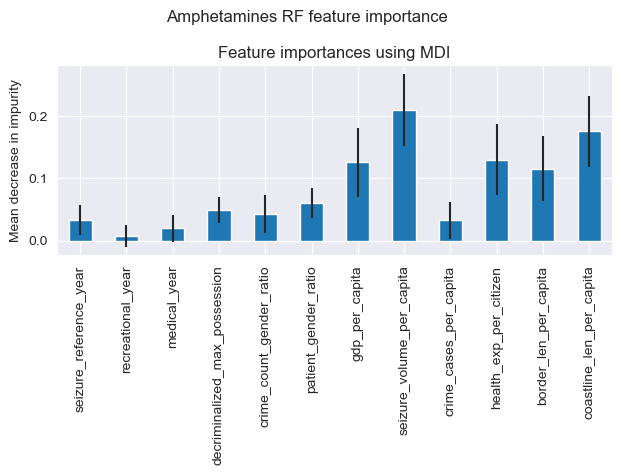

In [25]:
amphetmine_rf_feature_importance, amphetmine_rf_fi_errs = amphetamines_rf.get_feature_importance_scores()
vis_util.plot_rf_feature_importance(amphetmine_rf_feature_importance, amphetmine_rf_fi_errs, amphetamines_X_test.columns.tolist(), "Amphetamines RF feature importance", save_path="./images/amphetamines_rf_feature_importance.png")

**Lasso regression feature importance indication - using Shapley values**

PermutationExplainer explainer: 899it [00:20, 22.51it/s]                         


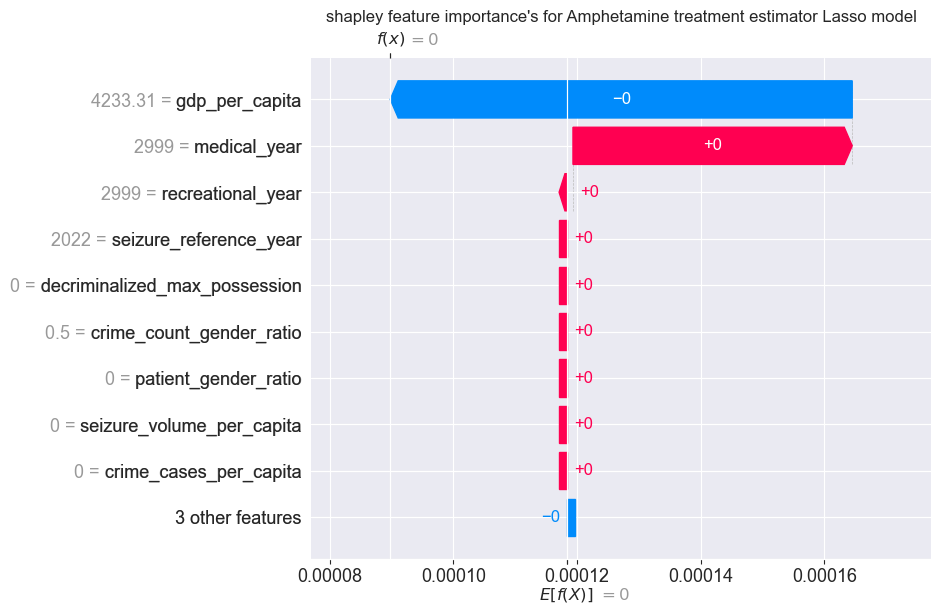

In [30]:
shap_vals_amphetamines = dputil.calc_shapley(amphetamines_lasso, amphetamines_X_train)
vis_util.plot_shapley_feature_importance(shap_vals_amphetamines, "shapley feature importance's for Amphetamine treatment estimator Lasso model", save_path="./images/amphetamines_lasso_shapley_feature_importance.png")

---
### Treatment per capita estimation for *Cocaine* type drugs
#### train-test split

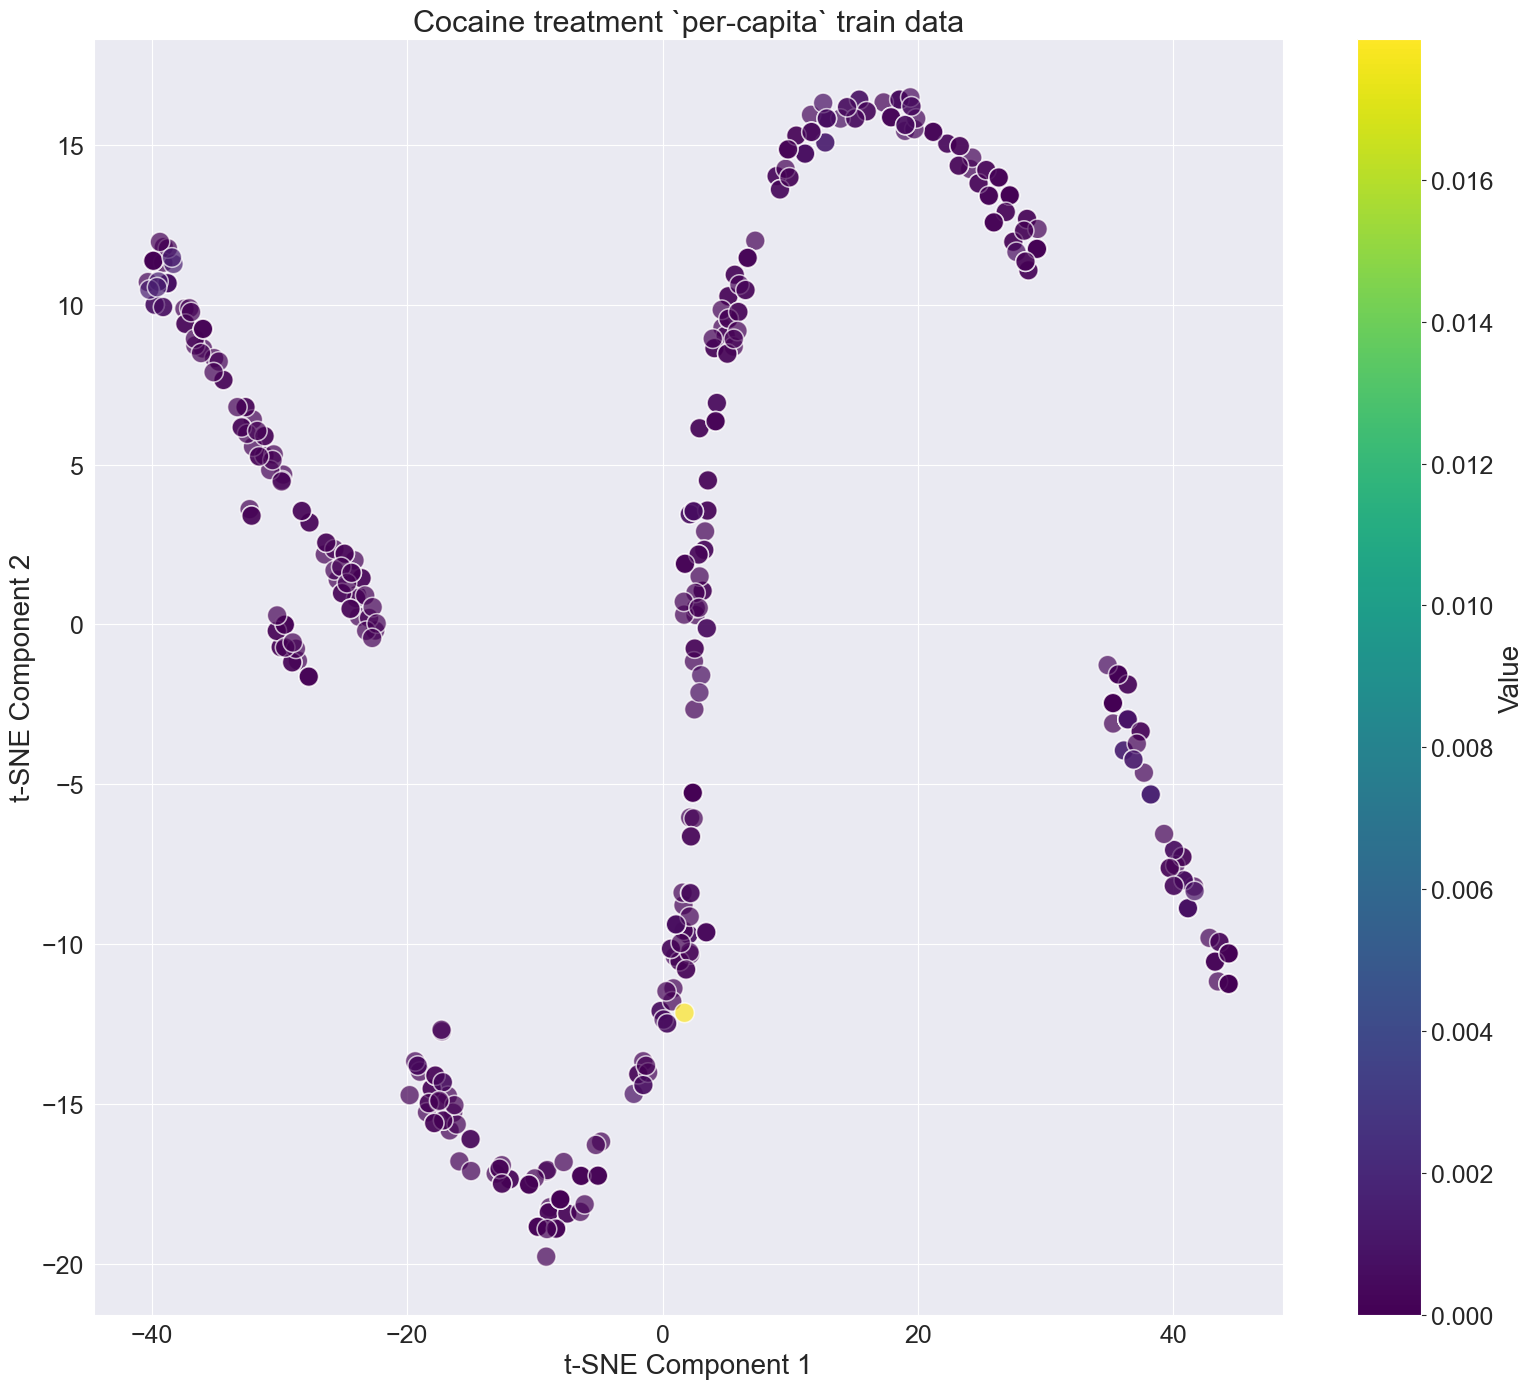

In [33]:
cocaine_y = cocaine_norm_df['treatments_per_capita'].values.reshape((-1, 1))
cocaine_X = cocaine_norm_df.copy().drop(columns=['treatments_per_capita']).select_dtypes(include='number')
cocaine_X_train, cocaine_X_test, cocaine_y_train, cocaine_y_test = train_test_split(cocaine_X,
                                                                                    cocaine_y,
                                                                                    test_size=0.15,
                                                                                    shuffle=True,
                                                                                    random_state=SEED)
vis_util.plot_tsne(cocaine_X_train, cocaine_y_train, 'Cocaine treatment `per-capita` train data',
                   colorbar=True)

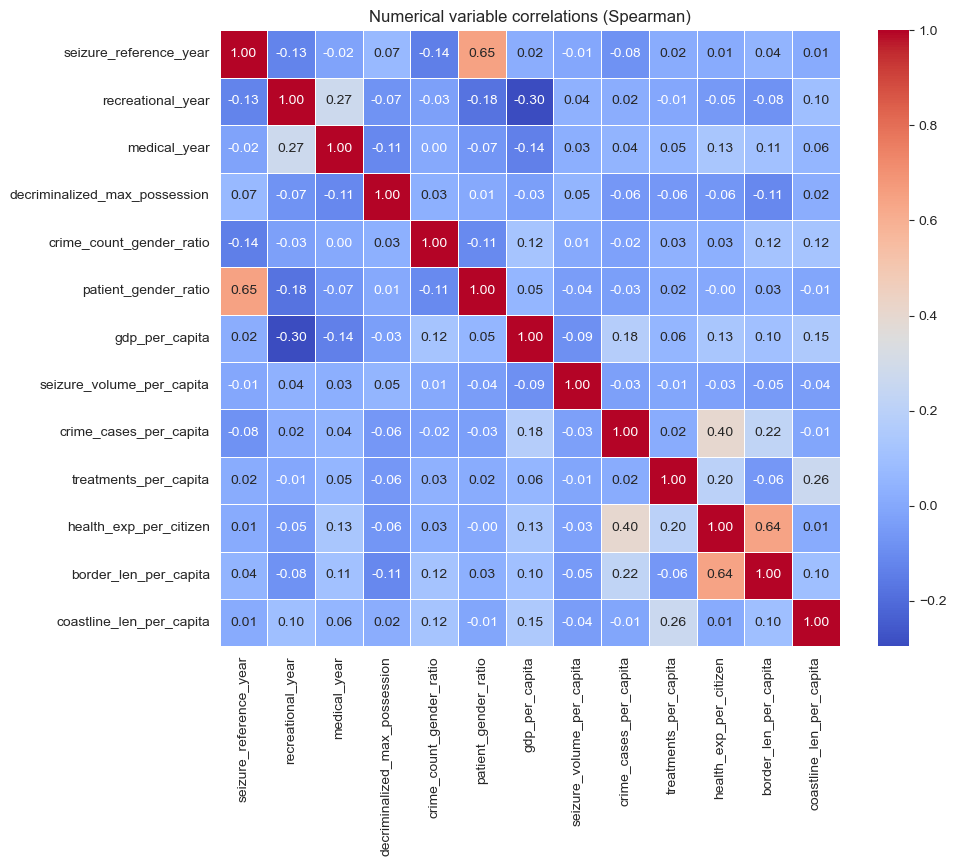

In [34]:
vis_util.plot_correlation_matrix(cocaine_norm_df.select_dtypes(include='number'),
                                 title="Numerical variable correlations (Spearman)", colors="coolwarm",
                                 save_path="./images/cocaine_correlation_matrix.png")

#### Linear models with regularization training
**L1 regularization - Lasso regression**

In [36]:
print("Init lasso model")
cocaine_lasso = LassoRegressionModel(SEED, n_iter=10000)
print("Done")
print("Training lasso model:")
cocaine_lasso.fit(cocaine_X_train, cocaine_y_train)
print("Done")
print(f"Alpha of best lasso model: {cocaine_lasso.best_alpha}")
cocaine_lasso.get_train_score(cocaine_X_train, cocaine_y_train)
print("Test lasso model:")
cocaine_lasso_y_pred = cocaine_lasso.predict(cocaine_X_test)
print("Cocaine lasso estimator test score:")
get_mad_score(cocaine_y_test, cocaine_lasso_y_pred, print_version=True)
get_r_square_score(cocaine_y_test, cocaine_lasso_y_pred, print_version=True)

Init lasso model
Done
Training lasso model:


C:\Users\User\.conda\envs\ds_lab\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10000. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Randomized search complete. Best alpha found: 0.1000
Done
Alpha of best lasso model: 0.1
Lasso regression R-squared score for train set: 0.0027
Test lasso model:
Cocaine lasso estimator test score:
MAD score for test set: 3.394574e-05
R-square score for test set: -8.424309e-03


**L2 regularization - Ridge regression**

In [38]:
print("Init ridge model")
cocaine_ridge = RidgeRegressionModel()
print("Done")
print("Training ridge model:")
cocaine_ridge.fit(cocaine_X_train, cocaine_y_train)
print("Done")
print(f"Alpha of best ridge model: {cocaine_ridge.alpha}")
print("Coefficients of model", cocaine_ridge.coefficients)
cocaine_ridge.get_train_score(cocaine_X_train, cocaine_y_train)
print("Test ridge model:")
cocaine_ridge_y_pred = cocaine_ridge.predict(cocaine_X_test)
print("Cocaine ridge estimator test score:")
get_mad_score(cocaine_y_test, cocaine_ridge_y_pred, print_version=True)
get_r_square_score(cocaine_y_test, cocaine_ridge_y_pred, print_version=True)

Init ridge model
Done
Training ridge model:
Done
Alpha of best ridge model: 10.0
Coefficients of model [ 1.88553655e-05 -2.17284313e-08  1.33599222e-07 -5.28480680e-06
  5.01290815e-05  7.34964536e-06  1.67045400e-09 -6.78335179e-06
 -5.59662696e-07  1.02703906e-07 -9.30664599e-07  7.55084517e-06]
Ridge regression R square score for train set: 1.220149e-02
Test ridge model:
Cocaine ridge estimator test score:
MAD score for test set: 1.055039e-04
R-square score for test set: -2.093234e-02


**Random Forest regression model**

In [39]:
print("Init RF model")
cocaine_rf = RandomForestModel(random_forest_param_dict, SEED)
print("Done")
print("Training RF model:")
cocaine_rf.fit(cocaine_X_train, cocaine_y_train)
print("Done")
cocaine_rf.get_train_score()
print("Test RF model:")
cocaine_rf_y_pred = cocaine_rf.predict(cocaine_X_test)
print("Cocaine RF estimator test score:")
get_mad_score(cocaine_y_test, cocaine_rf_y_pred, print_version=True)
get_r_square_score(cocaine_y_test, cocaine_rf_y_pred, print_version=True)

Init RF model
Done
Training RF model:


C:\Users\User\.conda\envs\ds_lab\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done
Random forest MAD score for train set: 6.252832e-01
Test RF model:
Cocaine RF estimator test score:
MAD score for test set: 7.568595e-06
R-square score for test set: 3.583791e-01


#### Cocaine model comparison

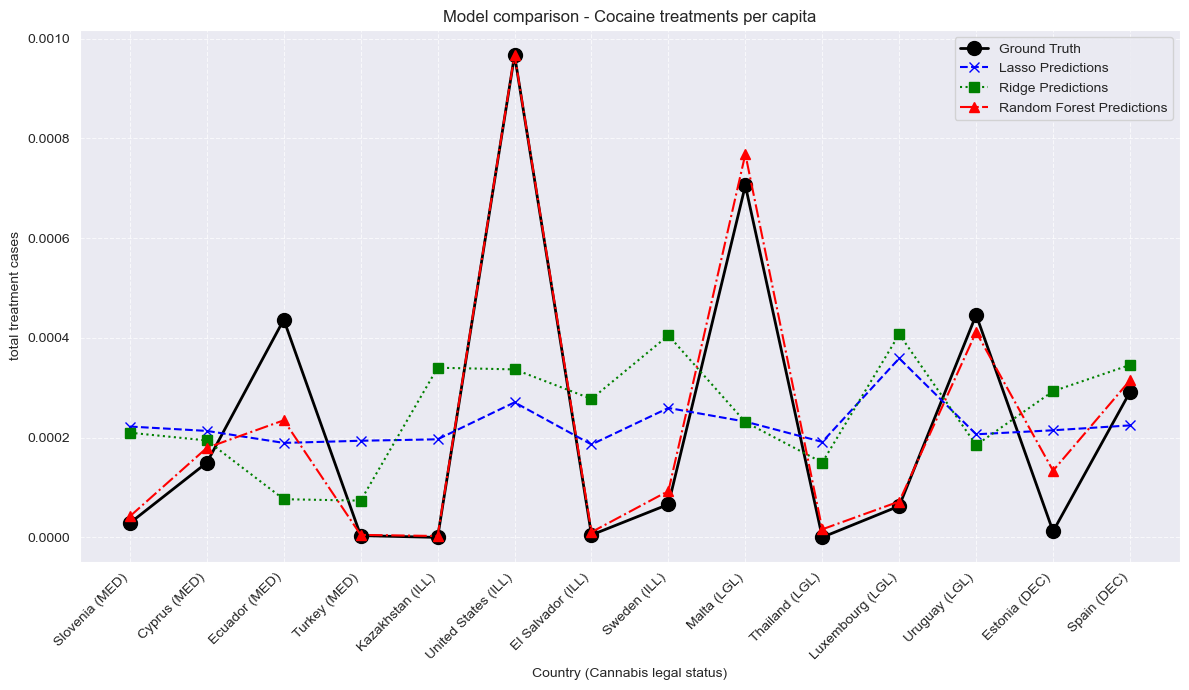

In [40]:
sample_df = dputil.create_subset_by_legal_category_for_plot(cocaine_norm_df.loc[cocaine_X_test.index, :],
                                                            {"lasso_preds": cocaine_lasso_y_pred,"ridge_preds": cocaine_ridge_y_pred,"rf_preds": cocaine_rf_y_pred})
vis_util.plot_model_predictions(gt_values=sample_df["treatments_per_capita"],
                                lasso_predictions=sample_df['lasso_preds'],
                                ridge_predictions=sample_df['ridge_preds'],
                                rf_predictions=sample_df['rf_preds'],
                                x_tick_labels=[f"{r['country']} ({r['legal_category']})" for _, r in sample_df.iterrows()],
                                title="Model comparison - Cocaine treatments per capita",
                                save_path="./images/cocaine_model_comparison.png")

#### Cocaine models feature importance
**Random Forest feature importance - using MDI**

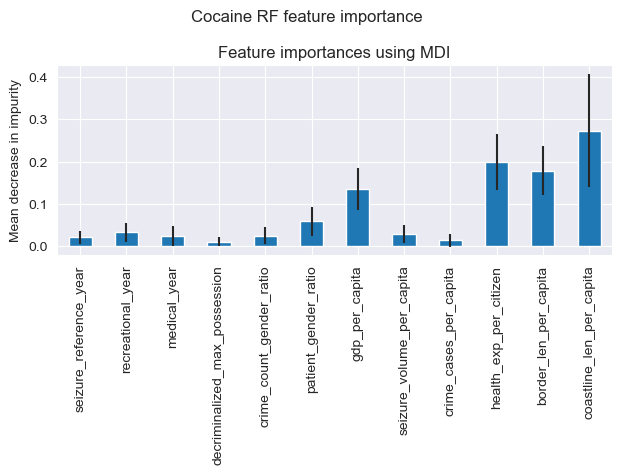

In [41]:
cocaine_rf_feature_importance, cocaine_rf_fi_errs = cocaine_rf.get_feature_importance_scores()
vis_util.plot_rf_feature_importance(cocaine_rf_feature_importance, cocaine_rf_fi_errs, cocaine_X_test.columns.tolist(), "Cocaine RF feature importance", save_path="./images/cocaine_rf_feature_importance.png")

**Lasso regression feature importance indication - using Shapley values**

PermutationExplainer explainer: 465it [00:10,  2.10it/s]                         


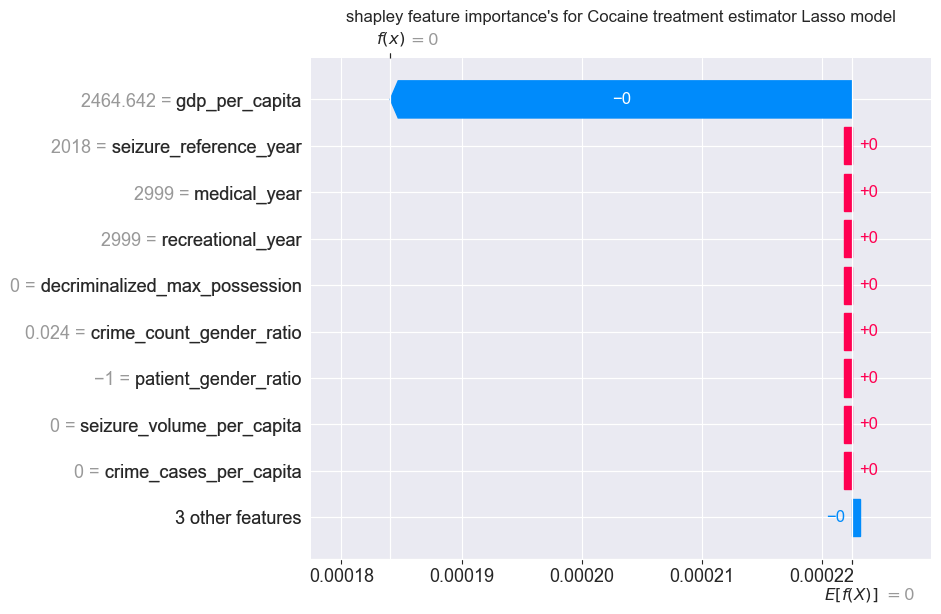

In [42]:
shap_vals_cocaine = dputil.calc_shapley(cocaine_lasso, cocaine_X_train)
vis_util.plot_shapley_feature_importance(shap_vals_cocaine, "shapley feature importance's for Cocaine treatment estimator Lasso model", save_path="./images/cocaine_lasso_shapley_feature_importance.png")

---
### Treatment per capita estimation for *Opioids* type drugs
#### train-test split

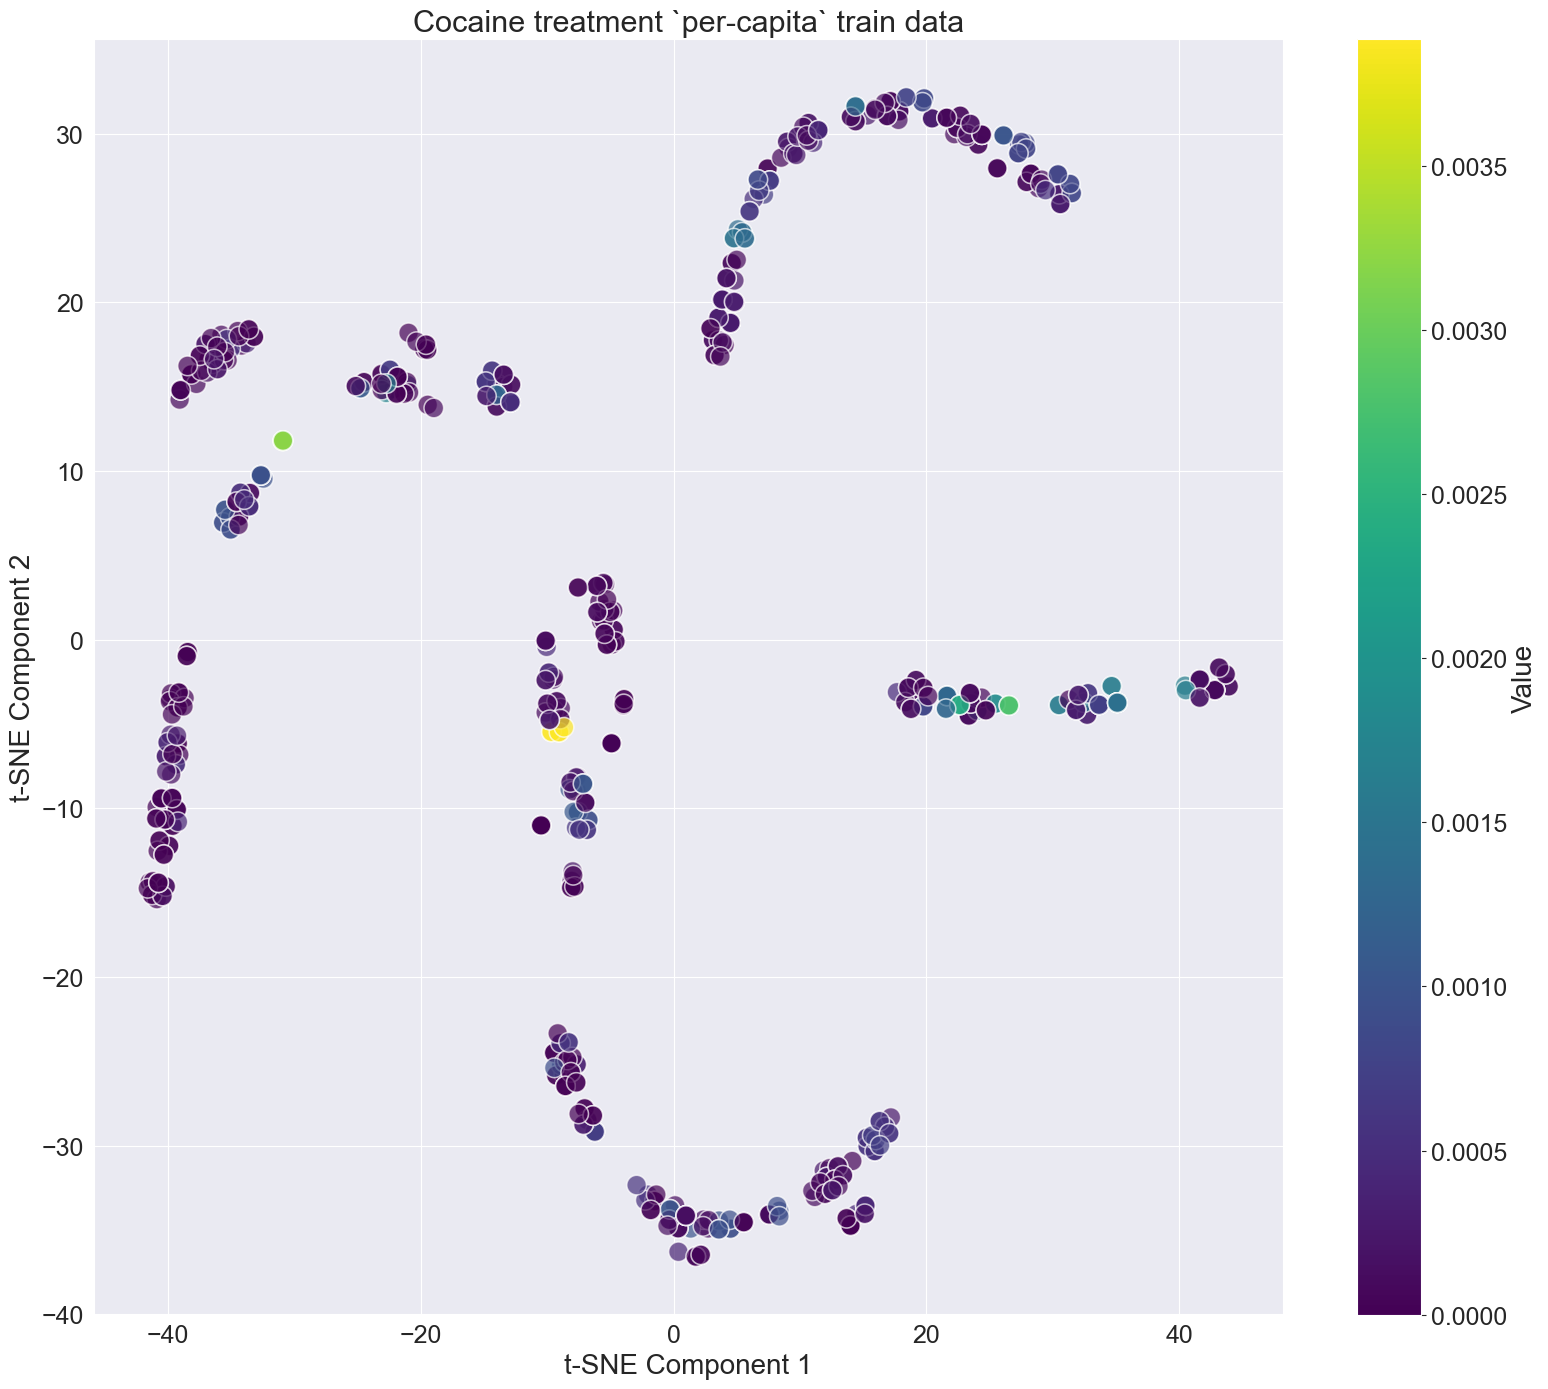

In [43]:
opioids_y = opioids_norm_df['treatments_per_capita'].values.reshape((-1, 1))
opioids_X = opioids_norm_df.copy().drop(columns=['treatments_per_capita']).select_dtypes(include='number')
opioids_X_train, opioids_X_test, opioids_y_train, opioids_y_test = train_test_split(opioids_X,
                                                                                    opioids_y,
                                                                                    test_size=0.15,
                                                                                    shuffle=True,
                                                                                    random_state=SEED)
vis_util.plot_tsne(opioids_X_train, opioids_y_train, 'Cocaine treatment `per-capita` train data',
                   colorbar=True)

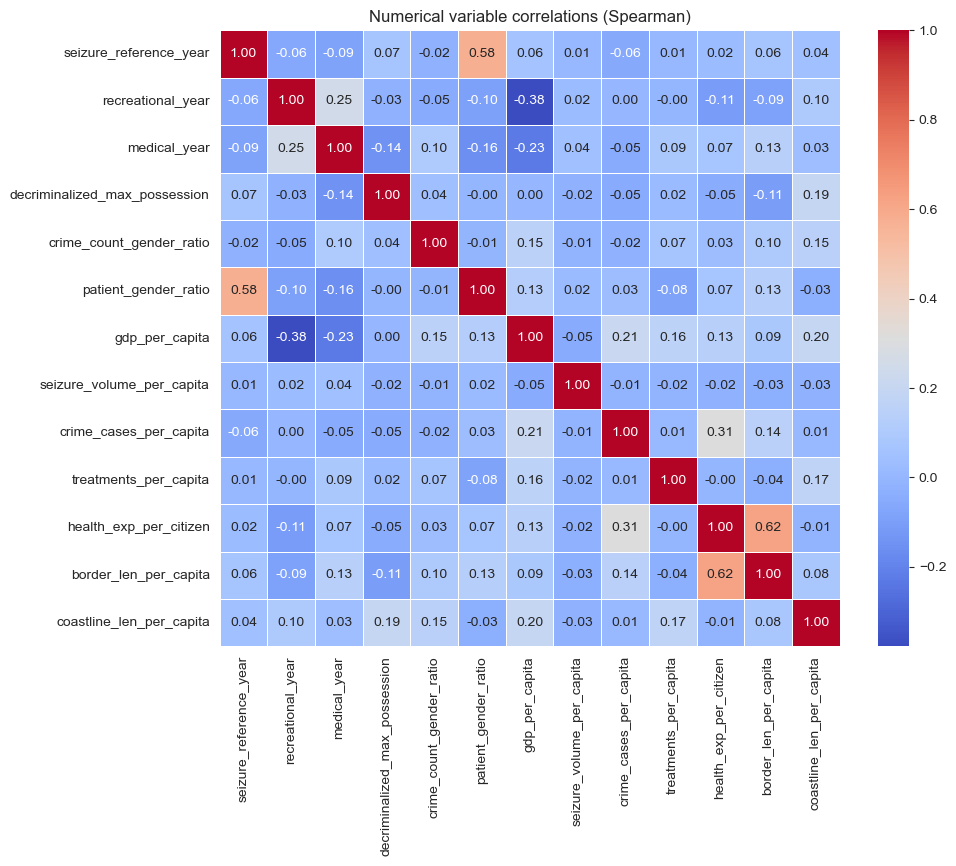

In [44]:
vis_util.plot_correlation_matrix(opioids_norm_df.select_dtypes(include='number'),
                                 title="Numerical variable correlations (Spearman)", colors="coolwarm",
                                 save_path="./images/opioids_correlation_matrix.png")

#### Linear models with regularization training
**L1 regularization - Lasso regression**

In [45]:
print("Init lasso model")
opioids_lasso = LassoRegressionModel(SEED, n_iter=10000)
print("Done")
print("Training lasso model:")
opioids_lasso.fit(opioids_X_train, opioids_y_train)
print("Done")
print(f"Alpha of best lasso model: {opioids_lasso.best_alpha}")
opioids_lasso.get_train_score(opioids_X_train, opioids_y_train)
print("Test lasso model:")
opioids_lasso_y_pred = opioids_lasso.predict(opioids_X_test)
print("Opioids lasso estimator test score:")
get_mad_score(opioids_y_test, opioids_lasso_y_pred, print_version=True)
get_r_square_score(opioids_y_test, opioids_lasso_y_pred, print_version=True)

Init lasso model
Done
Training lasso model:
Randomized search complete. Best alpha found: 0.0100
Done
Alpha of best lasso model: 0.01
Lasso regression R-squared score for train set: 0.0424
Test lasso model:
Opioids lasso estimator test score:
MAD score for test set: 6.795808e-05
R-square score for test set: 3.272905e-02


C:\Users\User\.conda\envs\ds_lab\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10000. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**Random Forest regression model**

In [47]:
print("Init RF model")
opioids_rf = RandomForestModel(random_forest_param_dict, SEED)
print("Done")
print("Training RF model:")
opioids_rf.fit(opioids_X_train, opioids_y_train)
print("Done")
opioids_rf.get_train_score()
print("Test RF model:")
opioids_rf_y_pred = opioids_rf.predict(opioids_X_test)
print("Opioids RF estimator test score:")
get_mad_score(opioids_y_test, opioids_rf_y_pred, print_version=True)
get_r_square_score(opioids_y_test, opioids_rf_y_pred, print_version=True)

Init RF model
Done
Training RF model:


C:\Users\User\.conda\envs\ds_lab\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done
Random forest MAD score for train set: 9.171995e-01
Test RF model:
Opioids RF estimator test score:
MAD score for test set: 1.775843e-05
R-square score for test set: 8.790453e-01


#### Opioids model comparison

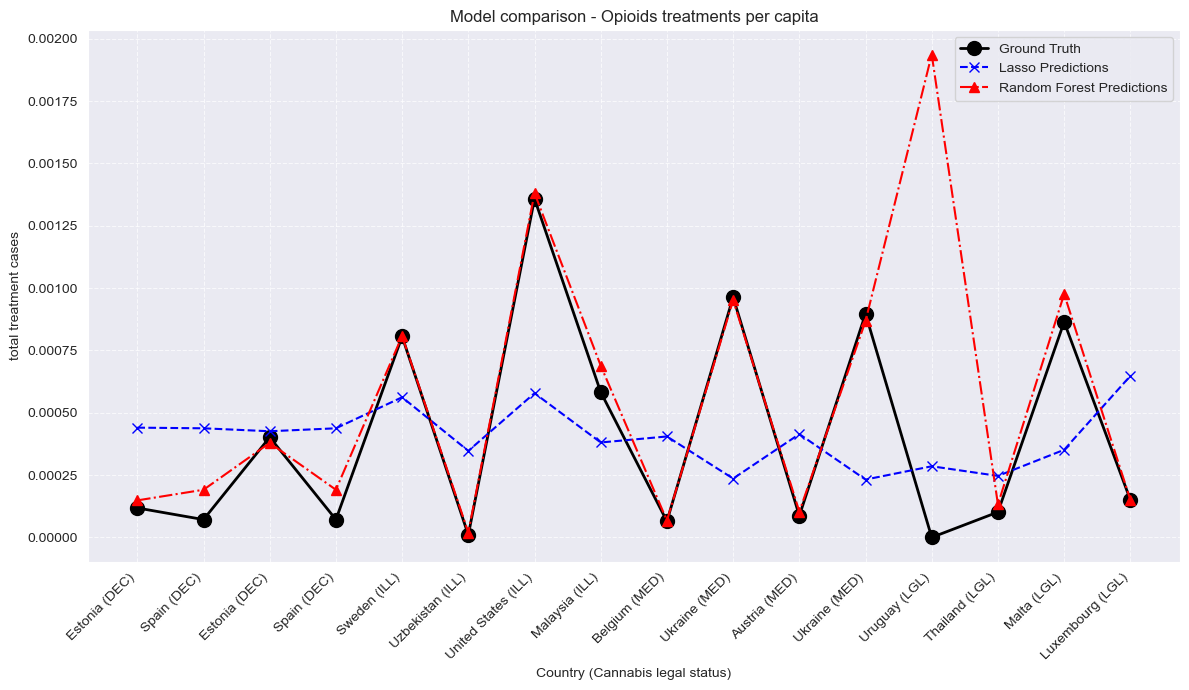

In [57]:
sample_df = dputil.create_subset_by_legal_category_for_plot(opioids_norm_df.loc[opioids_X_test.index, :],
                                                            {"lasso_preds": opioids_lasso_y_pred,"rf_preds": opioids_rf_y_pred})
vis_util.plot_model_predictions(gt_values=sample_df["treatments_per_capita"],
                                lasso_predictions=sample_df['lasso_preds'],
                                ridge_predictions=None,
                                rf_predictions=sample_df['rf_preds'],
                                x_tick_labels=[f"{r['country']} ({r['legal_category']})" for _, r in sample_df.iterrows()],
                                title="Model comparison - Opioids treatments per capita",
                                save_path="./images/opioids_model_comparison.png")

#### Opioids models feature importance
**Random Forest feature importance - using MDI**

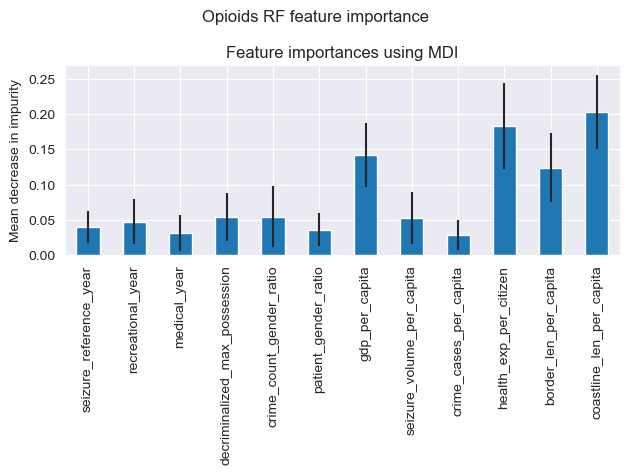

In [49]:
opioids_rf_feature_importance, opioids_rf_fi_errs = opioids_rf.get_feature_importance_scores()
vis_util.plot_rf_feature_importance(opioids_rf_feature_importance, opioids_rf_fi_errs, opioids_X_test.columns.tolist(), "Opioids RF feature importance", save_path="./images/opioids_rf_feature_importance.png")

**Lasso regression feature importance indication - using Shapley values**

PermutationExplainer explainer: 698it [00:16, 16.76it/s]                         


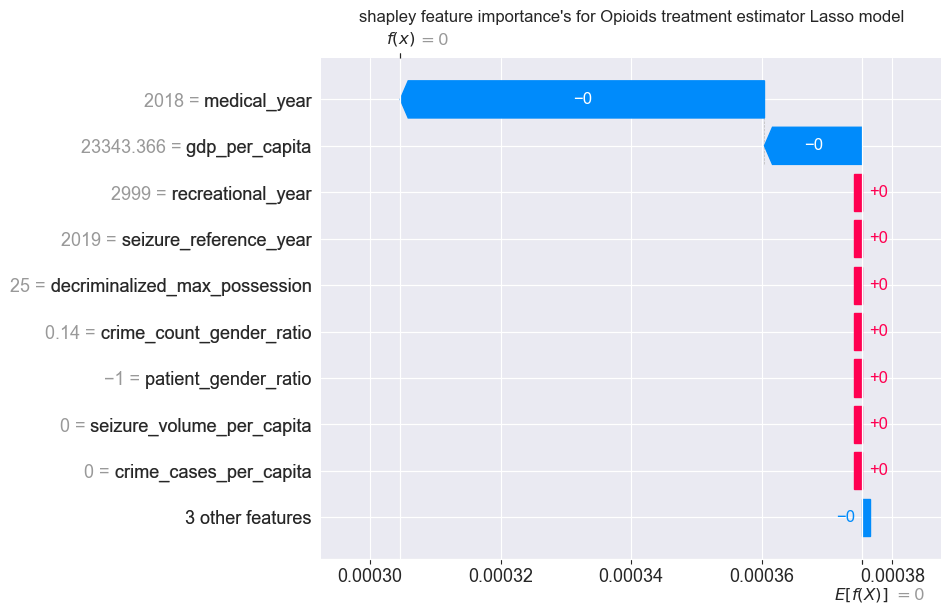

In [50]:
shap_vals_cocaine = dputil.calc_shapley(opioids_lasso, opioids_X_train)
vis_util.plot_shapley_feature_importance(shap_vals_cocaine, "shapley feature importance's for Opioids treatment estimator Lasso model", save_path="./images/opioids_lasso_shapley_feature_importance.png")

---
### Average model performance across all three drug types

In [51]:
y_trues_all_drugs = np.vstack([amphetamines_y_test, cocaine_y_test, opioids_y_test]).reshape((-1))

In [52]:
y_preds_rf_all_drugs = np.hstack([amphetamines_rf_y_pred, cocaine_rf_y_pred, opioids_rf_y_pred]).reshape((-1))

In [53]:
y_preds_lasso_all_drugs = np.hstack([amphetamines_lasso_y_pred, cocaine_lasso_y_pred, opioids_lasso_y_pred]).reshape((-1))

In [54]:
legal_status_all_test = np.hstack([amphetamines_norm_df.loc[amphetamines_X_test.index]['legal_category'],
                                cocaine_norm_df.loc[cocaine_X_test.index]['legal_category'],
                                opioids_norm_df.loc[opioids_X_test.index]['legal_category']]).reshape((-1))

In [55]:
countries_all_test = np.hstack([amphetamines_norm_df.loc[amphetamines_X_test.index]['country'],
                                cocaine_norm_df.loc[cocaine_X_test.index]['country'],
                                opioids_norm_df.loc[opioids_X_test.index]['country']]).reshape((-1))

**Lasso regression**

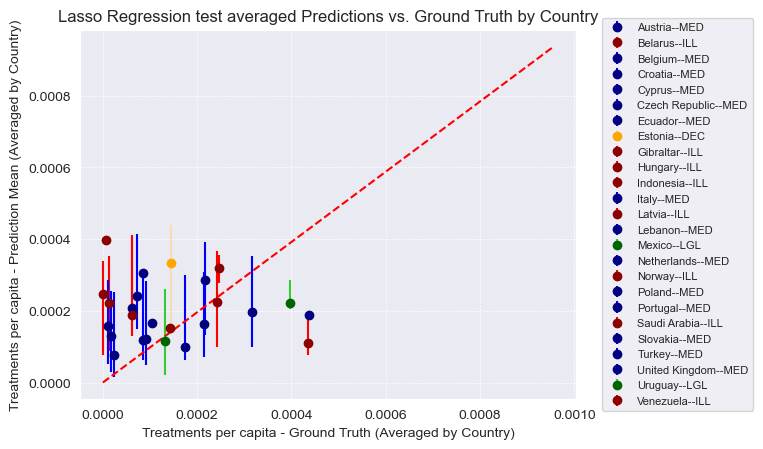

In [56]:
vis_util.plot_error_scatter(y_trues_all_drugs,
                            y_preds_lasso_all_drugs,
                            legal_status_all_test,
                            countries_all_test,
                            title="Lasso Regression test averaged Predictions vs. Ground Truth by Country",
                            save_path="images/lasso_test_errorbars.png"
                            )

**Random Forest**

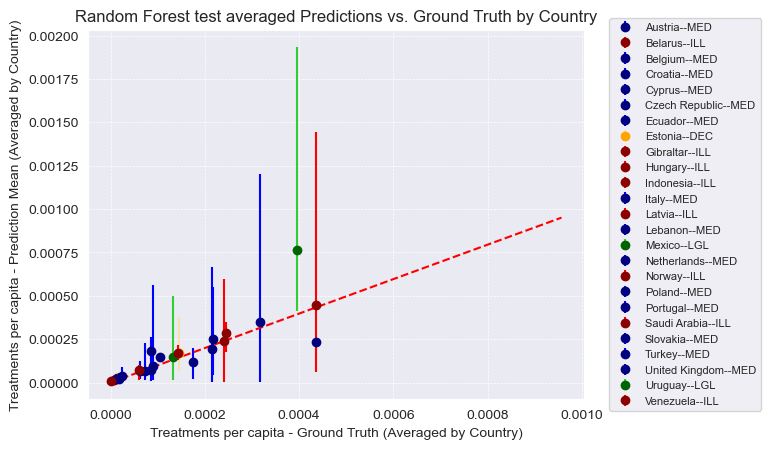

In [59]:
vis_util.plot_error_scatter(y_trues_all_drugs,
                             y_preds_rf_all_drugs,
                             legal_status_all_test,
                             countries_all_test,
                             title="Random Forest test averaged Predictions vs. Ground Truth by Country",
                             save_path="images/random_forest_test_errorbars.png"
                             )